# 8. 영화리뷰 텍스트 감성분석하기
레이블링이 완료된 영화리뷰를 학습시켜 '긍정' '부정'을 구분하는 모델을 만든다.

In [1]:
import pandas
import konlpy
import gensim

import tensorflow as tf

### 데이터 준비 및 확인
데이터를 받은 뒤 어떤 값들이 있는지 확인해보았다.

In [2]:
import pandas as pd

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


전처리(중복제거, 결측치 제거, 불용어 제거)를 진행하고 언어 tokenize 등을 한 뒤 훈련 데이터와 테스트 데이터로 나누는 load_data를 구현한다.

In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # train set 중복 제거, 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    # test set 중복 제거, 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # X_train 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)
    # X_test 토큰화 및 불용어 제거
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 10000-4만큼의 단어사전을 만든 다음, 나머지 4개를 pad, bos, unk, unused로 채운다.
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 문장을 index 값으로 저장(encode)
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

인코딩, 디코딩 함수를 만든다.

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

패딩을 위해 가장 긴 문장의 토큰수를 확인해 보았다.

In [5]:
tr_sentence_len=0
ts_sentence_len=0
for i in X_train:
    if tr_sentence_len < len(i):
        tr_sentence_len=len(i)
for i in X_test:
    if ts_sentence_len < len(i):
        ts_sentence_len=len(i)
print("train 데이터 최대길이:", tr_sentence_len)
print("test 데이터 최대길이:", ts_sentence_len)

train 데이터 최대길이: 116
test 데이터 최대길이: 105


train과 test데이터들을 통틀어 최대길이는 116 이므로, 최대 글자수도 116으로 맞췄다.

In [6]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', 
                                                        maxlen=120)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', 
                                                       maxlen=120)

validation set과 train set을 분리한다.

In [7]:
# validation set 50000건 분리
x_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 96182건
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

### 모델 형성
세 개의 모델을 형성해야 하지만 우선 하나의 모델에 집중한 뒤 나머지 모델을 형성해 보기로 하였다.

In [8]:
vocab_size = len(word_to_index)  # 어휘 사전의 크기
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 4)           40000     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

### 훈련 및 평가

In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 5s 7ms/step - loss: 0.5598 - accuracy: 0.6941 - val_loss: 0.3846 - val_accuracy: 0.8302
Epoch 2/20
227/227 [==============================] - 1s 6ms/step - loss: 0.3488 - accuracy: 0.8495 - val_loss: 0.3455 - val_accuracy: 0.8472
Epoch 3/20
227/227 [==============================] - 1s 5ms/step - loss: 0.3138 - accuracy: 0.8676 - val_loss: 0.3413 - val_accuracy: 0.8501
Epoch 4/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2959 - accuracy: 0.8771 - val_loss: 0.3436 - val_accuracy: 0.8513
Epoch 5/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2819 - accuracy: 0.8837 - val_loss: 0.3446 - val_accuracy: 0.8504
Epoch 6/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2701 - accuracy: 0.8898 - val_loss: 0.3518 - val_accuracy: 0.8501
Epoch 7/20
227/227 [==============================] - 1s 5ms/step - loss: 0.2595 - accuracy: 0.8952 - val_loss: 0.3593 - val_accuracy: 0.8480
Epoch 

In [10]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5050 - accuracy: 0.8278
[0.5050227046012878, 0.8277966380119324]


In [11]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 시각화
epoch에 따른 train set과 validation set의 Loss와 Accuracy를 측정해 보았다.

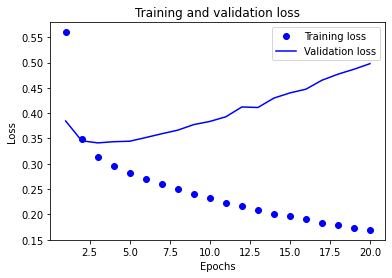

In [12]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

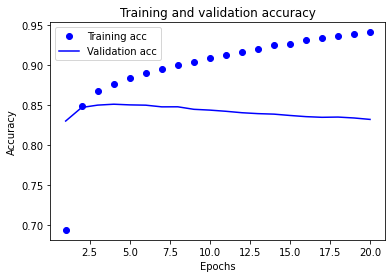

In [13]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 나머지 두 개의 모델을 마저 형성하고 실행시켜 보았다.

In [14]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 64  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                5184      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 645,329
Trainable params: 645,329
Non-trainable params: 0
_________________________________________________________________


In [15]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 4s 11ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 2/20
227/227 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 3/20
227/227 [==============================] - 2s 9ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 4/20
227/227 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 5/20
227/227 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 6/20
227/227 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 7/20
227/227 [==============================] - 2s 9ms/step - loss: 0.6931 - accuracy: 0.5015 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch

In [16]:
results2 = model2.evaluate(X_test,  y_test, verbose=2)

print(results2)

1537/1537 - 4s - loss: 0.6932 - accuracy: 0.4973
[0.6931712627410889, 0.4973045587539673]


In [17]:
history_dict2 = history2.history
print(history_dict2.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


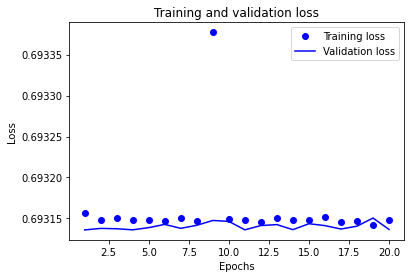

In [18]:
acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

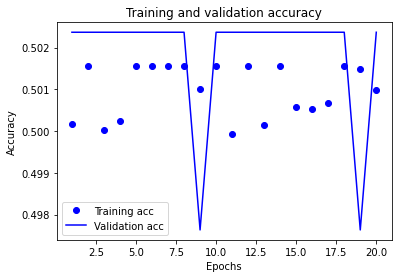

In [19]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
vocab_size = len(word_to_index)  # 어휘 사전의 크기
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40000     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


In [21]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 1s 4ms/step - loss: 0.6615 - accuracy: 0.6553 - val_loss: 0.5998 - val_accuracy: 0.7147
Epoch 2/20
227/227 [==============================] - 1s 4ms/step - loss: 0.5507 - accuracy: 0.7292 - val_loss: 0.5217 - val_accuracy: 0.7441
Epoch 3/20
227/227 [==============================] - 1s 4ms/step - loss: 0.5043 - accuracy: 0.7543 - val_loss: 0.5070 - val_accuracy: 0.7565
Epoch 4/20
227/227 [==============================] - 1s 4ms/step - loss: 0.4877 - accuracy: 0.7651 - val_loss: 0.5032 - val_accuracy: 0.7587
Epoch 5/20
227/227 [==============================] - 1s 3ms/step - loss: 0.4786 - accuracy: 0.7708 - val_loss: 0.5027 - val_accuracy: 0.7587
Epoch 6/20
227/227 [==============================] - 1s 3ms/step - loss: 0.4727 - accuracy: 0.7743 - val_loss: 0.5028 - val_accuracy: 0.7584
Epoch 7/20
227/227 [==============================] - 1s 3ms/step - loss: 0.4684 - accuracy: 0.7763 - val_loss: 0.5035 - val_accuracy: 0.7583
Epoch 

In [22]:
results3 = model3.evaluate(X_test,  y_test, verbose=2)

print(results3)

1537/1537 - 2s - loss: 0.5174 - accuracy: 0.7545
[0.5173766613006592, 0.7545212507247925]


In [23]:
history_dict3 = history3.history
print(history_dict2.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


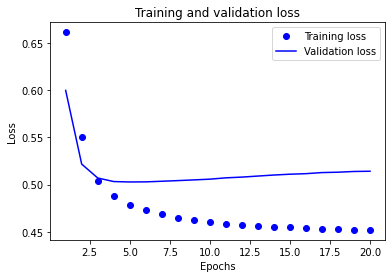

In [24]:
acc = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

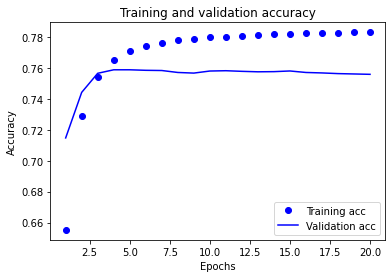

In [25]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

다른 방식으로 모델을 적용해본 결과 첫번째와 세번째 모델은 그럭저럭 결과가 나왔지만, 두번째 모델은 학습 그래프도 이상하고 accuracy도 낮았다. 왜 그런지 이유를 계속 찾아봤지만 코드상으로 이상한 부분이 없어서 모델에 문제가 있는 것으로 결론지었다.

### Word2vec 적용
두번째 모델의 이상 원인을 찾다 보니 시간이 많이 지났지만, 되는 데까지 Word2vec을 적용해 보도록 한다. 적용하기에 앞서, gensim에서 제공하는 패키지를 이용해 word vector를 읽은 뒤 입력한 단어와 유사한 단어를 검출해 보았다.

In [26]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 4)


In [27]:
index_to_word={index:word for word, index in word_to_index.items()}

In [28]:
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [29]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
# 저장한 파일에 대해 gensim을 사용하여 다시 벡터를 읽어들인다.
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.01459834,  0.013228  , -0.04419923,  0.01967694], dtype=float32)

In [30]:
# 영화와 비슷한 단어를 찾아보았다.
word_vectors.similar_by_word("영화")

[('알아들', 0.999006986618042),
 ('르', 0.997790515422821),
 ('셔야', 0.9968621134757996),
 ('아픕니다', 0.9916253685951233),
 ('띄', 0.9873903393745422),
 ('어제', 0.9872888922691345),
 ('브로디', 0.9869462847709656),
 ('다', 0.9856691956520081),
 ('사이프리드', 0.9805638194084167),
 ('나타나', 0.9778562188148499)]

과연 이 단어들이 영화와 어떤 관계가 있을까 싶기도 하지만 영화 제목이나 영화 혹은 영화배우에 대한 설명이 들어가는 것처럼 보이는 부분도 분명히 있다.  

In [42]:
from gensim.models import KeyedVectors

word2vec_path = os.getcwd()+'/sentiment_classification/data/word2vec_ko.model'

word2vec = KeyedVectors.load(word2vec_path)

In [43]:
vector = word2vec.wv['영화']
vector

array([-1.8007389 , -1.1790098 , -2.4066596 ,  2.1384156 , -0.3537603 ,
        1.3749527 , -4.894612  , -3.6517198 ,  0.4411444 ,  0.78153926,
       -2.696888  , -1.7812852 , -2.1514654 , -4.813236  ,  2.7465918 ,
       -2.1620324 , -0.11467794, -1.2431171 ,  2.3979309 , -1.1060628 ,
       -0.41043055,  1.9500391 ,  0.7821002 ,  1.5899978 ,  1.6447444 ,
       -2.1265035 , -1.7981595 ,  1.7535795 ,  0.53717697, -1.212121  ,
       -4.466316  ,  4.5488324 ,  1.334441  , -0.9070271 ,  1.1931889 ,
        4.1563215 ,  1.9758307 , -0.9437562 , -0.2592725 ,  0.34935686,
        1.8562875 , -3.3249645 ,  1.1221625 ,  1.2836524 ,  3.9211376 ,
        3.8023994 ,  2.766269  ,  0.67293745,  2.2853644 , -5.1131716 ,
        0.32525915, -3.3079958 ,  5.3043513 , -3.8813758 , -0.32960036,
       -1.9527504 ,  3.8865075 , -3.5470378 , -0.21991685,  0.82119733,
       -0.9492492 ,  3.5472107 ,  1.322048  , -0.70640826,  0.52253807,
        1.4683235 , -1.1018689 ,  2.262941  , -0.7204685 , -1.76

In [46]:
word2vec.wv.similar_by_word("영화")

[('드라마', 0.8418774008750916),
 ('뮤지컬', 0.7775140404701233),
 ('코미디', 0.7489107251167297),
 ('다큐멘터리', 0.7401294708251953),
 ('헐리우드', 0.7397844195365906),
 ('애니메이션', 0.7170552015304565),
 ('독립영화', 0.7113528251647949),
 ('로맨틱', 0.7107657194137573),
 ('장편', 0.7101576924324036),
 ('극영화', 0.7045413255691528)]

단어장의 사이즈가 더 커서 그런지 훨씬 밀접해 보이는 단어들이 좀 더 설명력 있는 확률로 나와 있음을 확인할 수 있었다.  
마지막으로, 예제에 나온 모델을 활용하여 학습을 진행해 보았다.

In [50]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [54]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=120, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 100)          1000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 114, 16)           11216     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 22, 16)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 16, 16)            1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [55]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 2s 8ms/step - loss: 0.5723 - accuracy: 0.6953 - val_loss: 0.5013 - val_accuracy: 0.7606
Epoch 2/20
227/227 [==============================] - 2s 7ms/step - loss: 0.4530 - accuracy: 0.7923 - val_loss: 0.4299 - val_accuracy: 0.8039
Epoch 3/20
227/227 [==============================] - 2s 7ms/step - loss: 0.3917 - accuracy: 0.8254 - val_loss: 0.3926 - val_accuracy: 0.8239
Epoch 4/20
227/227 [==============================] - 2s 7ms/step - loss: 0.3538 - accuracy: 0.8469 - val_loss: 0.3734 - val_accuracy: 0.8353
Epoch 5/20
227/227 [==============================] - 2s 7ms/step - loss: 0.3251 - accuracy: 0.8621 - val_loss: 0.3603 - val_accuracy: 0.8418
Epoch 6/20
227/227 [==============================] - 2s 7ms/step - loss: 0.3053 - accuracy: 0.8733 - val_loss: 0.3583 - val_accuracy: 0.8443
Epoch 7/20
227/227 [==============================] - 2s 7ms/step - loss: 0.2877 - accuracy: 0.8820 - val_loss: 0.3582 - val_accuracy: 0.8464
Epoch 

In [57]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5000 - accuracy: 0.8352
[0.4999726712703705, 0.8352422118186951]


accuracy가 엄청나게 오른 것은 아니지만, 학습 모델 중 가장 뛰어나다고 할 수 있을 것 같다.

회고  
아무 이유 없이 이번 회차는 개인적으로 선호하지 않는 회차였고, 과제를 할 때도 알 수 없거나 자잘한 이유, 노드의 불친절함 등의 문제로 시간을 오래 끈 과제였다. 모델 중 하나가 다른 사람들도 쓰는 노드의 모델을 그대로 가져온 것인데 잘 작동하지 않아 몇 시간씩 잡아먹거나(루브릭이나 별 개수에 영향을 미치진 않지만 정말 잡고 싶었다...) word2vec_ko.model파일만 사용하는 것이 아니라 다른 파일도 필요하다는 사실을 몰라서 'no such file or directory' 오류를 보고 있자니 어이없다는 생각이 드는 노드였던 것 같다.  
그래도 한가지 좋았던 점이 있다면 여러 방식으로 model을 만져볼 수 있었던 것이다. 제출시에는 노드의 모델을 차용하였지만, 이런저런 방식으로 layer를 쌓고 모델을 만져본 경험은 아직 성과로 연결되지 않았다 하더라도 나쁘지 않았다.  
마지막으로, 다음 과제는 좀 일찍 해야겠다.  